# Covid-19 infección en Ecuador. Modelos probabilisticos
Implementacion de un modelo probabilistico de infección por el virus Covid-19

Se realiza un análisis probabilistico simple del crecimiento de la infección en Python y el modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de probabilidad.

In [1]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
import sympy as sym
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline








In [29]:
# Actualizar los datos (URL)
url = 'https://covid.ourworldindata.org/data/ecdc/new_cases.csv'
df = pd.read_csv(url)
df

date  World  Afghanistan  Albania  Algeria  Andorra  Angola  \
0    2019-12-31     27          0.0      NaN      0.0      NaN     NaN   
1    2020-01-01      0          0.0      NaN      0.0      NaN     NaN   
2    2020-01-02      0          0.0      NaN      0.0      NaN     NaN   
3    2020-01-03     17          0.0      NaN      0.0      NaN     NaN   
4    2020-01-04      0          0.0      NaN      0.0      NaN     NaN   
..          ...    ...          ...      ...      ...      ...     ...   
109  2020-04-18  83324         51.0     21.0    150.0     14.0     0.0   
110  2020-04-19  84121         63.0      9.0    117.0      8.0     5.0   
111  2020-04-20  74139         88.0     14.0     94.0      9.0     0.0   
112  2020-04-21  75852         35.0     22.0     89.0      4.0     0.0   
113  2020-04-22  88817         61.0     25.0     93.0      0.0     0.0   

     Anguilla  Antigua and Barbuda  Argentina  ...  United States  \
0         NaN                  NaN        NaN  ...              0   
1         NaN                  NaN        NaN  ...              0   
2         NaN                  NaN        NaN  ...              0   
3         NaN                  NaN        NaN  ...              0   
4         NaN                  NaN        NaN  ...              0   
..        ...                  ...        ...  ...            ...   
109       0.0                  0.0       98.0  ...          30833   
110       0.0                  0.0      170.0  ...          32922   
111       0.0                  0.0      102.0  ...          24601   
112       0.0                  0.0       90.0  ...          28065   
113       0.0                  1.0      112.0  ...          37289   

     United States Virgin Islands  Uruguay  Uzbekistan  Vatican  Venezuela  \
0                             NaN      NaN         NaN      NaN        NaN   
1                             NaN      NaN         NaN      NaN        NaN   
2                             NaN      NaN         NaN      NaN        NaN   
3                             NaN      NaN         NaN      NaN        NaN   
4                             NaN      NaN         NaN      NaN        NaN   
..                            ...      ...         ...      ...        ...   
109                           0.0     18.0        70.0      0.0       23.0   
110                           2.0     18.0        45.0      0.0        0.0   
111                           0.0      4.0        70.0      0.0       29.0   
112                           1.0     10.0        92.0      1.0        0.0   
113                           0.0     11.0        35.0      0.0       29.0   

     Vietnam  Yemen  Zambia  Zimbabwe  
0        0.0    NaN     NaN       NaN  
1        0.0    NaN     NaN       NaN  
2        0.0    NaN     NaN       NaN  
3        0.0    NaN     NaN       NaN  
4        0.0    NaN     NaN       NaN  
..       ...    ...     ...       ...  
109      1.0    0.0     4.0       0.0  
110      0.0    0.0     5.0       1.0  
111      0.0    0.0     4.0       0.0  
112      0.0    0.0     4.0       0.0  
113      0.0    0.0     0.0       3.0  

[114 rows x 208 columns]

Imprimos los resultados y agregamos el numero del dia


In [30]:
df = df.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
# Exresar las fechas en numero de dias desde el 01 Enero

FMT = '%Y-%m-%d'
date = df['date']
print(date)
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df

0      2019-12-31
1      2020-01-01
2      2020-01-02
3      2020-01-03
4      2020-01-04
          ...    
109    2020-04-18
110    2020-04-19
111    2020-04-20
112    2020-04-21
113    2020-04-22
Name: date, Length: 114, dtype: object


date  Ecuador
0      -1      0.0
1       0      0.0
2       1      0.0
3       2      0.0
4       3      0.0
..    ...      ...
109   108    225.0
110   109    572.0
111   110    446.0
112   111    660.0
113   112    270.0

[114 rows x 2 columns]

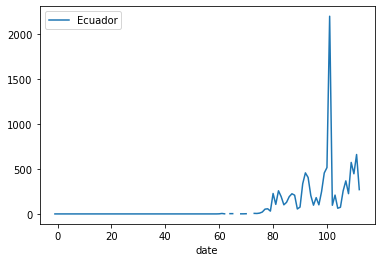

In [4]:
df.plot(x ='date', y='Ecuador')

Ahora podemos analizar un modelo probabilisto para el examen.

## El modelo basado en probabilidad

Para realizar un estimacion del factor de crecimiento de los casos de Covid 19 en Ecuador calculamos la mediana, con esto obtenemo el valor medio de crecimiento de un conjunto de datos, con esto podemos obtener un factor de crecimiento o taza de crecimiento de los nuevos casos.



In [5]:
filtro = df["Ecuador"][61:] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
#print(filtro)
media = filtro.mean()
mediana = filtro.median()
print('media',mediana)
print('mediana',media)


media 117.5
mediana 216.625


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [6]:
#Vamos a comprobar:
# según la media y la mediana podemos obtener la taza de crecieminto y predicir su comportamiento.
# Cargamos los datos de total de casos
url = 'https://covid.ourworldindata.org/data/ecdc/total_cases.csv'
df_t = pd.read_csv(url)
FMT = '%Y-%m-%d'
date = df_t['date']
df_t['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df_t = df_t.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis

df_t = df_t[df_t['Ecuador'] >= 1]
#print(df_t)

yreal = list(df_t.iloc [:, 1]) # Total casos
xreal = list(df_t.iloc [:, 0]) # Dias
xpred = xreal
ypred = yreal

#Realizamos un ejemplo de prediccion
print('dia actual:',xreal[-1])
prediccion_siguiente = int(ypred[-1] + mediana)
print('actual: ',ypred[-1],'prediccion',prediccion_siguiente)

dia actual: 112
actual:  10398.0 prediccion 10515


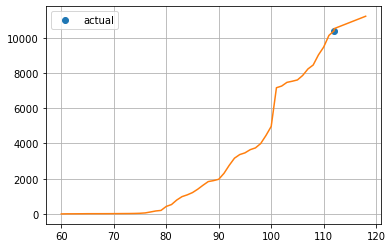

118

In [7]:
# Quiero predecir cuántos "Casos" voy a obtener de aqui a 10 dias.

plt.plot(xreal[-1],yreal[-1],'o',label='actual')
for i in range(xpred[-1], xpred[-1]+7):
    xpred.append(i)
    ypred.append(int(ypred[-1] + mediana))
    

plt.plot(xpred, ypred)
plt.grid(True)
plt.legend()
plt.show()

xpred[-1]

# Practica

1. Comparar el modelo de predicion matematico vs probabilidad.
2. Generar el SIR en base al modelo de probabilidad y obtener beta y gamma con una semana de prediccion.
3. Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.

Puntos extras: Investigas sobre la correlacion de variables y aplicar el calculo en base a los datos del Ecuador.

# 1. Comparar el modelo de predicion matematico vs probabilidad.


112


D:\Users\Diego\anaconda3\envs\simulacion\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


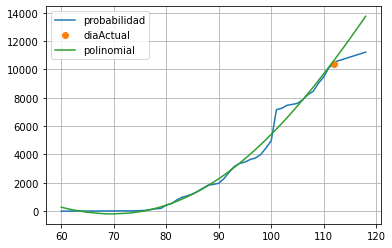

In [13]:

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import sympy as sym

diasProyeccion=7

yreal = list(df_t.iloc [:, 1]) # Total casos
xreal = list(df_t.iloc [:, 0]) # Dias
#df2 = df_t[df_t['Ecuador'] >= 1]


#x1 = list(df2.iloc [:, 0]) # Dias
#y1 = list(df2.iloc [:, 1]) # Total casos



#for i in range(x1[-1], x1[-1]+diasProyeccion):
 #   x1.append(i)
  #  y1.append(int(y1[-1] + mediana))




#plt.plot(x1, y1, 'ro',label="Original Data")
xpol = np.array(xpred, dtype=float) #transform your data in a numpy array of floats 
ypol = np.array(ypred, dtype=float) #s

def func(x, a, b, c, d,e):
    return a*x**4 + b*x**3 +c*x**2 + d*x + 3

#entrenamos con los datos reales sin prediccion usamos estos datos dado que ya esta con los valores aumentados pero no calculamos con eso
popt, pcov = curve_fit(func, xreal, yreal)






plt.plot(xpred, ypred,label='probabilidad')
plt.plot(xreal[-1],yreal[-1],'o',label='diaActual')
print(xreal[-1])
plt.plot(xpol, func(xpol, *popt), label="polinomial") #same as line above \/



plt.grid(True)
plt.legend(loc='upper left')
plt.show()#Implementar

# 2. Generar el SIR en base al modelo de probabilidad y obtener beta y gamma con una semana de prediccion.


valor beta: 0.29964537340996467 valor gamma:  0.018966220205089746 valor R0 15.798897733432003


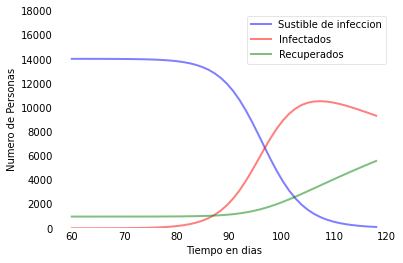

In [9]:
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.integrate import odeint

#los datos son mas 7 dias de la fecha actual
dfprobabilidad = pd.DataFrame([xpred,ypred])
dfprobabilidad = dfprobabilidad.transpose()
dfprobabilidad.columns = ['date', 'Ecuador']
data=dfprobabilidad


#N = 166200000
N=15000
# Numero Inicial de Infectados
I0 = 1
# Numero de Recuperados
R0 = 970
# Todos los demás, S0, son susceptibles a la infección inicialmente.
S0 = N - I0 - R0


def errorCuadratico(point, data, S0, I0, R0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/N, beta*S*I/N-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [S0,I0,R0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

optimo = minimize(
    errorCuadratico,
    [0.001, 0.001],
    args=(data.Ecuador, S0, I0, R0),
    method='L-BFGS-B',
    bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
    )
    
beta, gamma = optimo.x
print('valor beta:' ,beta,'valor gamma: ',gamma,'valor R0',beta/gamma)




#t = np.linspace(0, 500, 500)


#print(data)

t= np.linspace(min(xpred), xpred[-1])
# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Vector de condiciones iniciales
y0 = S0, I0, R0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T # Obtenicion de resultados


#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recuperados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
ax.set_ylim(0,N*1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
#plt.grid(True)


plt.grid(True)

plt.show()

Ro = beta/gamma
#print(Ro)
#print(R)

# 3. Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.

media 97.0
mediana 185.4390243902439


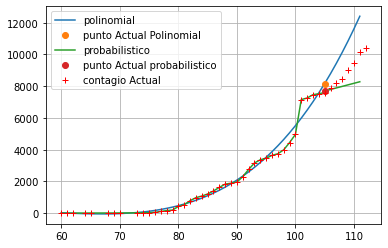

In [12]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import sympy as sym


#nuevos valores de x menos los 7 dias 
newx=xreal[:-7]
newy=yreal[:-7]


def func(x, a, b, c, d,e):
    return a*x**4 + b*x**3 +c*x**2 + d*x + 3
#netrenar la curva
popt, pcov = curve_fit(func, newx, newy)

##mediana de los datos sin 7 dias
filtro = df["Ecuador"][61:-7]
media = filtro.mean()
mediana = filtro.median()
print('media',mediana)
print('mediana',media)



for i in range(newx[-1], newx[-1]+7):
    newx.append(i)
    newy.append(int(newy[-1] + mediana))


#transdfromacion para el polinomial
x = np.array(newx, dtype=float) #transform your data in a numpy array of floats 
y = np.array(newy, dtype=float) #s


plt.plot(x, func(x, *popt), label="polinomial") #same as line above \/
plt.plot(x[-7], func(x[-7], *popt), 'o',label="punto Actual Polinomial") #
plt.plot(newx,newy,label='probabilistico')
plt.plot(newx[-7],newy[-7],'o',label='punto Actual probabilistico')

plt.plot(xreal,yreal,'+r',label='contagio Actual')


plt.legend(loc='upper left')
plt.grid(True)
plt.show()#Implementar



## Analisis
en las graficas podemos observar un gran similitud entre la prediccion probabilistica que se basa en la mediana  y el polinomial , el probabilistico podemos observar que genera una curva hacia la izquierda la cual indica un valor estable de incremento debido a que cada dia que pasa se incrementa n cantidad de personas  por dia, por su contrario en la polinomial el incremento es paulatino es decir se incrementa se forma continua un valor mayor cada dia.
en el modelo sir con nuestro porcentaje de poblacion se ve que cada dia se acerca a el maximo contagio .
## Conclusiones
el modelo probabilisto se mantien en una linea perpendicular que no se asemeja a la realidad , por su contrario el polinomial muestra como se va incrementando en la actualidad dado que el nivel de contagio cada dia se incrementa mucho. pero como conclucion generar en el ultimo punto podemos observar como de ninguno de nestros mosdelos ya sea el de la media o el de polinomial se acercan tanto a los datos reales.

## Criterio personal (politico, economico y  social de la situacion)
en cuento a lo politico se ve como no pueden manejrar los problemas internos dados por el covid
En lo economico afecta total mente debido a que muchos necesitams del dia a dia normal para poder suscistir
En cuanto a lo sociedad podemos observar que tan dificil es acotar las leyes establecidas



# Referencias

- https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia

- https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/